In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
%precision 2

'%.2f'

In [2]:
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging
logging.basicConfig(level=logging.INFO)

In [3]:
epoch_key = ('bon', 3, 2)

In [4]:
from src.parameters import (ANIMALS, SAMPLING_FREQUENCY,
                            MULTITAPER_PARAMETERS, FREQUENCY_BANDS,
                            RIPPLE_COVARIATES)

In [5]:
from src.data_processing import (get_interpolated_position_dataframe,
                              get_LFP_dataframe,
                              get_mark_indicator_dataframe,
                              get_spike_indicator_dataframe,
                              make_neuron_dataframe,
                              make_tetrode_dataframe, reshape_to_segments,
                              save_xarray)

In [6]:
tetrode_info = (
    make_tetrode_dataframe(ANIMALS)
    .loc[epoch_key]
    .set_index(['animal', 'day', 'epoch', 'tetrode_number'],
               drop=False))
tetrode_info

animal       area  day    depth descrip  \
animal day epoch tetrode_number                                           
bon    3   2     1                 bon        CA3    3  [[149]]     NaN   
                 2                 bon        CA3    3  [[151]]     NaN   
                 3                 bon        CA1    3  [[100]]     NaN   
                 4                 bon        CA1    3  [[107]]     NaN   
                 5                 bon        CA1    3  [[105]]     NaN   
                 6                 bon        NaN    3    [[0]]     NaN   
                 7                 bon        CA3    3  [[162]]     NaN   
                 8                 bon        CA3    3  [[153]]     NaN   
                 9                 bon        NaN    3      NaN     NaN   
                 10                bon        CA3    3  [[146]]     NaN   
                 11                bon        CA1    3   [[95]]     NaN   
                 12                bon        CA1    3  [[136]]     NaN   
                 13                bon        CA1    3   [[93]]     NaN   
                 14                bon        CA1    3   [[96]]     NaN   
                 15                bon        NaN    3    [[0]]     NaN   
                 16                bon        NaN    3      NaN     NaN   
                 17                bon        CA1    3  [[108]]     NaN   
                 18                bon        CA3    3  [[138]]     NaN   
                 19                bon        CA3    3  [[130]]     NaN   
                 20                bon        CA3    3  [[132]]     NaN   
                 21                bon        CA3    3  [[146]]     NaN   
                 22                bon        CA3    3  [[171]]     NaN   
                 23                bon        CA3    3  [[152]]     NaN   
                 24                bon        CA1    3  [[109]]     NaN   
                 25                bon        CA3    3  [[144]]     NaN   
                 26                bon        NaN    3      NaN     NaN   
                 27                bon        ???    3  [[157]]     NaN   
                 28                bon        CA1    3  [[100]]     NaN   
                 29                bon        CA1    3  [[118]]     NaN   
                 30                bon  Reference    3    [[0]]     NaN   

                                 epoch hemisphere  maxcell  nearCA2  numcells  \
animal day epoch tetrode_number                                                 
bon    3   2     1                   2      right      NaN      0.0       6.0   
                 2                   2      right      NaN      0.0       0.0   
                 3                   2      right      NaN      0.0       3.0   
                 4                   2      right      NaN      0.0       0.0   
                 5                   2      right      NaN      0.0       5.0   
                 6                   2        NaN      NaN      NaN       0.0   
                 7                   2      right      NaN      0.0       0.0   
                 8                   2      right      NaN      0.0       0.0   
                 9                   2        NaN      NaN      NaN       NaN   
                 10                  2      right      NaN      0.0       0.0   
                 11                  2      right      NaN      0.0       0.0   
                 12                  2       left      NaN      0.0       2.0   
                 13                  2       left      NaN      0.0       1.0   
                 14                  2       left      NaN      0.0       2.0   
                 15                  2        NaN      NaN      NaN       0.0   
                 16                  2        NaN      NaN      NaN       NaN   
                 17                  2       left      NaN      0.0       1.0   
                 18                  2       left      NaN      0.0       3.0   
           

In [7]:
mark_variables = ['channel_1_max', 'channel_2_max', 'channel_3_max',
                  'channel_4_max']
hippocampal_tetrodes = tetrode_info.loc[
    tetrode_info.area.isin(['CA1', 'iCA1', 'CA3']) &
    ~tetrode_info.descrip.str.endswith('Ref').fillna(False), :]

position_info = get_interpolated_position_dataframe(epoch_key, ANIMALS)

marks = [(get_mark_indicator_dataframe(tetrode_key, ANIMALS)
          .loc[:, mark_variables])
         for tetrode_key in hippocampal_tetrodes.index]
marks = [tetrode_marks for tetrode_marks in marks
         if (tetrode_marks.loc[position_info.speed > 4, :].dropna()
             .shape[0]) != 0]

In [8]:
position = position_info.loc[position_info.speed > 4].linear_position.values
spike_marks = np.stack(marks, axis=0)[:, (position_info.speed > 4).values, :]
trajectory_direction = position_info.loc[position_info.speed > 4].trajectory_direction.values

In [9]:
from src.ripple_decoding import ClusterlessDecoder

decoder = ClusterlessDecoder(position, trajectory_direction, spike_marks,
                             n_position_bins=122,
                             observation_state_order=['Inbound', 'Outbound'],
                             state_transition_state_order=['Inbound', 'Outbound'],
                             state_names=['Inbound', 'Outbound'], replay_speedup_factor=1)
decoder.fit();

/Users/edeno/anaconda3/envs/Jadhav-2016-Data-Analysis/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
INFO:src.ripple_decoding.decoders:Fitting state transition model...
INFO:src.ripple_decoding.decoders:Fitting observation model...


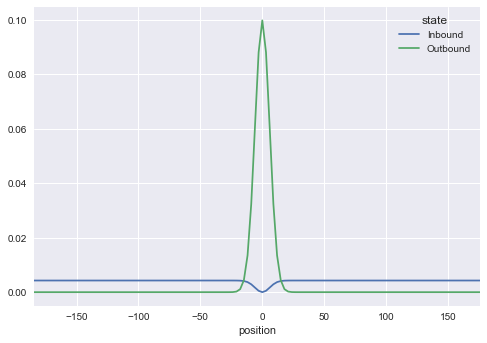

In [10]:
decoder.plot_initial_conditions()

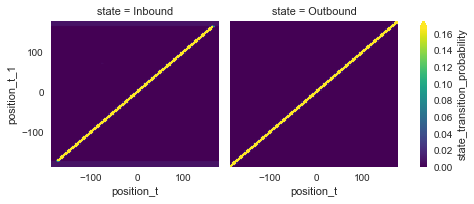

In [11]:
decoder.plot_state_transition_model();

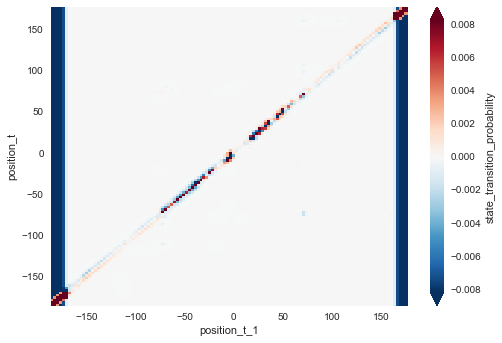

In [12]:
state_transition = decoder.state_transition_matrix

(state_transition.sel(state='Outbound') - state_transition.sel(state='Inbound')).plot(
    x='position_t_1', y='position_t', robust=True);

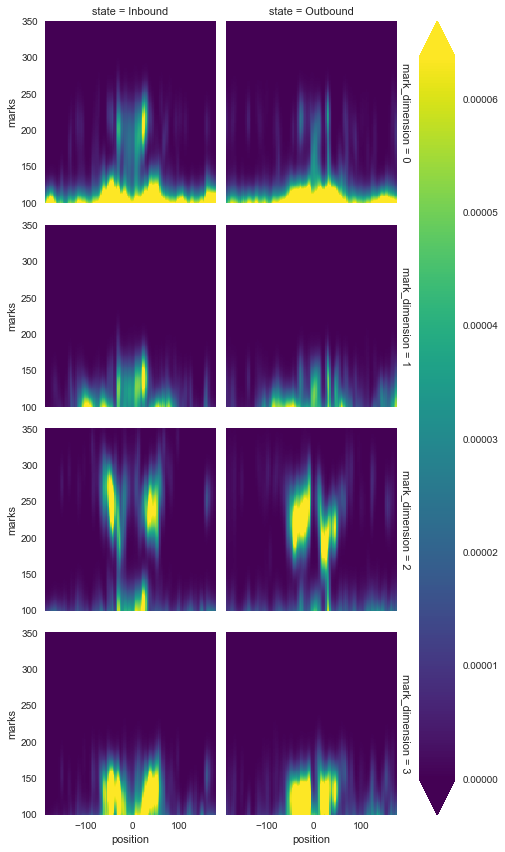

In [13]:
decoder.marginalized_intensities().isel(signal=2).plot(
    x='position', y='marks', col='state', row='mark_dimension', robust=True);

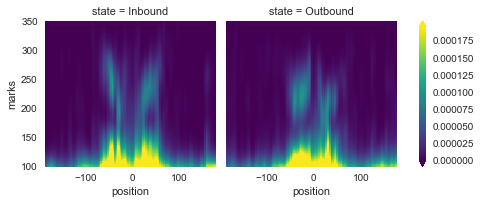

In [14]:
decoder.marginalized_intensities().isel(signal=2).sum('mark_dimension').plot(
    x='position', y='marks', col='state', robust=True);